# Medzy

## Overview

This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medecine or to check if the cleric gave the correct medicine.

This model will use Tensor flows' keras convolutional neural network as reference to this <a href = "https://www.tensorflow.org/tutorials/images/cnn">documentation</a>. The model will also be trained using this <a href="https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset">dataset</a> from kaggle.

## Importing needed libraries

In [1]:
# basic python libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np
import os
import glob

# data preprocessing libraries
from sklearn.preprocessing import LabelEncoder

# tensor flow libraries
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Fine tuning libraries
import keras_tuner

## Importing the Data

### Train data

#### Train Labels

In [2]:
train_path = "./Dataset/archive/dataset/Training"
train_labels = pd.read_csv(os.path.join(train_path,"training_labels.csv"), delimiter = ",")

In [3]:
train_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [4]:
medicine_enc = LabelEncoder()
train_name_enc = to_categorical(medicine_enc.fit_transform(train_labels["MEDICINE_NAME"]), num_classes=78)
# train_labels["MEDICINE_NAME_ENC"] = train_name_enc

In [5]:
len(train_labels["MEDICINE_NAME"].unique())

78

after encoding there are 78 unique values/medicines since we are using label encoder, we will put them all in to a seperate column

#### Train Images

In [6]:
#the image width and height to pass to the model
img_width = 420
img_height = np.round(img_width/3, 0).astype("int")

In [7]:
train_images = []
train_files = glob.glob("./Dataset/archive/dataset/training/training_words/*.png")
for picture in train_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))
    
    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    res, image = cv2.threshold(image,210,255,cv2.THRESH_BINARY)
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,1)
    # image = cv2.GaussianBlur(image,(5,5),5)
    res, image = cv2.threshold(image,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    res, image = cv2.threshold(image,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    
    train_images.append(image)
    # image = np.asarray(image) # for numpy 1.23
    
    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()
    
train_images = np.array(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# Shuffling the data
BUFFER_SIZE = len(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

In [8]:
print("Dataset shape:", train_images[0].shape)
print("Labels shape:", train_labels.shape) 

Dataset shape: (140, 420)
Labels shape: (3120, 3)


##### Check if it is correct

In [9]:
train_images[1]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

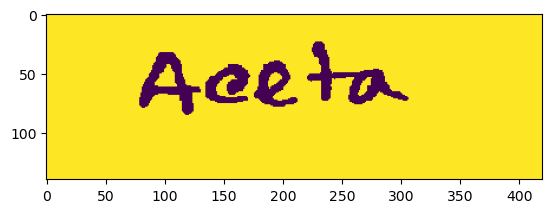

In [10]:
plt.imshow(train_images[1])

In [11]:
print("Example label:", train_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Validation data

#### validation Labels

In [12]:
validation_path = "./Dataset/archive/dataset/Validation"
validation_labels = pd.read_csv(os.path.join(validation_path,"validation_labels.csv"), delimiter = ",")

In [13]:
validation_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [14]:
validation_name_enc = to_categorical(medicine_enc.transform(validation_labels["MEDICINE_NAME"]), num_classes=78)
# validation_labels["MEDECINE_NAME_ENC"] = validation_name_enc

In [15]:
type(validation_name_enc)

numpy.ndarray

In [16]:
len(validation_labels["MEDICINE_NAME"].unique())

78

#### Validation Images

In [17]:
validation_images = []
validation_files = glob.glob("./Dataset/archive/dataset/Validation/validation_words/*.png")
for picture in validation_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))
    
    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    res, image = cv2.threshold(image,210,255,cv2.THRESH_BINARY)
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,1)
    # image = cv2.GaussianBlur(image,(5,5),5)
    res, image = cv2.threshold(image,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    res, image = cv2.threshold(image,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    
    validation_images.append(image)
    # image = np.asarray(image) # for numpy 1.23
    
    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()
    
validation_images = np.array(validation_images)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# Shuffling the data
BUFFER_SIZE = len(validation_images)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)

In [18]:
print("Dataset shape:", validation_images.shape)
print("Labels shape:", validation_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

In [19]:
validation_images[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

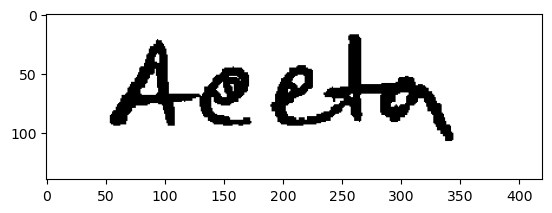

In [20]:
plt.imshow(validation_images[0], cmap = "gray")

In [21]:
print("Example label:", validation_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Test data

#### Test Labels

In [22]:
test_path = "./Dataset/archive/dataset/Testing"
test_labels = pd.read_csv(os.path.join(test_path,"testing_labels.csv"), delimiter = ",")

In [23]:
test_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [24]:
test_name_enc = to_categorical(medicine_enc.transform(test_labels["MEDICINE_NAME"]), num_classes=78)
# test_labels["train_medecine_name_enc"] = test_name_enc

In [25]:
len(test_labels["MEDICINE_NAME"].unique())

78

#### Testing Images

In [26]:
test_images = []
test_files = glob.glob("./Dataset/archive/dataset/Testing/testing_words/*.png")
for picture in test_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))
    
    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    res, image = cv2.threshold(image,210,255,cv2.THRESH_BINARY)
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,1)
    # image = cv2.GaussianBlur(image,(5,5),5)
    res, image = cv2.threshold(image,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    res, image = cv2.threshold(image,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    
    test_images.append(image)
    # image = np.asarray(image) # for numpy 1.23
    
    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()
    
test_images = np.array(test_images)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffling the data
BUFFER_SIZE = len(test_images)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

In [27]:
print("Dataset shape:", test_images.shape)
print("Labels shape:", test_labels.shape) 

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

In [28]:
test_images[0].shape

(140, 420)

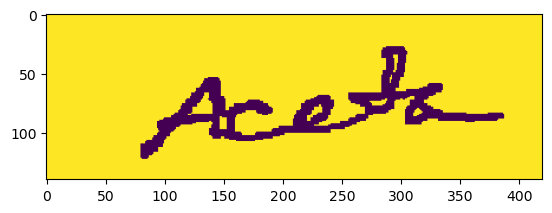

In [29]:
plt.imshow(test_images[0])

In [30]:
print("Example label:", test_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


## Building the artificial neural network

#### Make a model create function

##### Parameters for the model

In [31]:
#number of classes to determine how many neurons are in the output layer
num_classes = len(train_labels["MEDICINE_NAME"].unique())
num_classes

78

In [32]:
#the image size to determine the shape for the convolutional neural network to scan
train_images[0].shape

(140, 420)

#### Custom f1 score metric

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Create a model builder for gridsearch

the even filter shapes aren't recommended because it lacks the ability to devide the previous layer pixels arould the output pixel <a hre = "https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15">(Pandey, 2020)</a>.

<a href = "https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759">Machine Learning in Plain English (2023)</a> The most common activation functions are "relu" and "leaky relu" therefore we would pass it in the grid search.

Max pooling excells in image classification, due to how max pooling captures the most prominent features and reduce the variance of the input <a href = "https://www.linkedin.com/advice/1/how-do-you-choose-appropriate-pooling-method-2uvmc#adaptive-pooling">(Awad et. al, n.d.)</a>.

In [ ]:
def create_model(hp):
    input_shape = (img_height, img_width, 1)
    model = Sequential()
    metrics = ['accuracy', 
            Precision(name = 'precision'),
            Recall(name = 'recall'),
            f1_score]
    
    #input layer. The shape of the input layer must be huge to scale down the image. Ideally (5x5) or (7x7)
    model.add(layers.Conv2D(filters = hp.Choice("input_filter", [32, 64, 128]),
                            kernel_size = hp.Choice("input_kernel_size", [3,5,7]),
                            activation = hp.Choice("input_activation", ["relu", "leaky_relu"]),
                            input_shape = input_shape))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    #Convolutional layer
    for i in range(hp.Choice("n_conv_layers", [1,3])):
        model.add(layers.Conv2D(filters = hp.Choice(f"conv_filter_{i}", [32, 64, 128]),
                            kernel_size = hp.Choice(f"conv_kernel_size_{i}", [3,5,7]),
                            activation = hp.Choice(f"conv_activation_{i}", ["relu", "leaky_relu"])))
        if i < 1:
            model.add(layers.MaxPooling2D(pool_size=2))
        
    #Flatten the resulted image so that the dense layer could extract the patterns and categorize it
    model.add(layers.Flatten())
    
    # intermediate layer (note: from previous grid searches, by using only one intermediate layer achived the best score)
    model.add(layers.Dense(hp.Choice(f"n_neurons_dense_{i}", [256, 512, 1024]), 
                        activation = hp.Choice(f"dense_activation{i}", ["relu", "leaky_relu"])))
        
    #Output layer
    #there are 78 classes in the output layer so we will take 78 neurons to classify it
    model.add(layers.Dense(78, activation = "softmax"))
    
    #optimizers (contributed by Rayhan)
    optimizer_name = hp.Choice('optimizer', ['adamw', 'sgd', 'rmsprop'])

    if optimizer_name == 'adamw':
        optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]), weight_decay=1e-4)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]), momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]), rho=0.9)
    
    model.compile(metrics = metrics, loss = "categorical_crossentropy")
    
    return model

In this project, a hyperband gridsearch will be used since the hyperband tuner will stop training the model if the accuracy is low on the validation data <a href = "https://medium.com/analytics-vidhya/automated-hyperparameter-tuning-with-keras-tuner-and-tensorflow-2-0-31ec83f08a62#:~:text=Overview%20of%20available%20Keras%20Tuners,Tuners%20available%2C%20as%20of%20now.&text=The%20basic%20and%20least%20efficient,from%20a%20search%20space%20randomly.&text=A%20Hyperband%20tuner%20is%20an,accuracy%20on%20the%20validation%20set.&text=Bayesian%20Optimization%20works%20the%20same,Keras%20Tuner%20with%20the%20Documentation.">(Bag, 2021)</a>. 

In [35]:
# tuner_hyperband = keras_tuner.Hyperband(
#     hypermodel = create_model,
#     objective= keras_tuner.Objective("val_recall", 
#                                      direction='max'),
#     max_epochs=20,
#     factor = 5,
#     hyperband_iterations=1, #the number of itterations that the model will go trough the hyperband algorithm
#     seed = 42, #for reproducibility
#     overwrite = True,
#     # directory = "model_train_log", #to store logs on the trial results
#     # project_name = "medzy"
# )

In [36]:
# Bayesian optimization
tuner_bayes = keras_tuner.BayesianOptimization(
    hypermodel = create_model,
    objective= keras_tuner.Objective("val_recall", 
                                     direction='max'),
    max_trials = 100,
    seed = 42,
    overwrite = True
)

In [37]:
tuner_gridSearch = keras_tuner.GridSearch(
    hypermodel = create_model,
    objective = keras_tuner.Objective("val_recall", 
                                     direction='max'),
    seed = 42,
    overwrite = True
)

#### Start the grid search

In [ ]:
validation_steps = len(validation_images) #the number of validation for number of batches

tuner_gridSearch.search(
    train_images,
    train_name_enc,
    epochs = 100,
    validation_data = (validation_images, validation_name_enc), #data used to evaluate the model after each epoch
    validation_steps = validation_steps, #number of batches used for validation
    callbacks = [keras.callbacks.EarlyStopping(
            monitor="val_recall",  # Metric to monitor
            patience=2,  # Number of epochs with no improvement before stopping
            mode="max",  # Since we want to maximize recall
            restore_best_weights=True,  # Restores the best model weights at the end
            verbose=1  # Prints when early stopping happens
            ), 
            keras.callbacks.EarlyStopping(
                monitor = "val_f1_score",
                patience = 2,
                mode = "max",
                restore_best_weights = True,
                verbose = 1
            ),
            keras.callbacks.EarlyStopping(
                monitor = "val_precision",
                patience = 2,
                mode = "max",
                restore_best_weights = True,
                verbose = 1
            )]
)

Trial 10 Complete [00h 17m 19s]
val_recall: 0.006410256493836641

Best val_recall So Far: 0.006410256493836641
Total elapsed time: 01h 15m 34s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
32                |32                |input_filter
3                 |3                 |input_kernel_size
relu              |relu              |input_activation
1                 |1                 |n_conv_layers
32                |32                |conv_filter_0
3                 |3                 |conv_kernel_size_0
relu              |relu              |conv_activation_0
1024              |1024              |n_neurons_dense_0
leaky_relu        |relu              |dense_activation0
adam              |rmsprop           |optimizer

Epoch 1/20
98/98 [==============================] - 141s 1s/step - loss: 214.9576 - accuracy: 0.0391 - precision: 0.0440 - recall: 0.0115 - f1_score: 0.0140 - val_loss: 5.2832 - val_accuracy: 0.0167 - val_precision: 0.0000e+00 - val_rec

In [ ]:
best_hp = tuner_gridSearch.get_best_hyperparameters()[0]
best_hp.values

{'input_filter': 32,
 'input_kernel_size': 7,
 'input_activation': 'relu',
 'n_conv_layers': 1,
 'conv_filter_0': 64,
 'conv_kernel_size_0': 3,
 'conv_activation_0': 'leaky_relu',
 'n_dense_layer': 1,
 'n_neurons_dense_0': 512,
 'dense_activation0': 'relu',
 'optimizer': 'rmsprop',
 'conv_filter_1': 64,
 'conv_kernel_size_1': 3,
 'conv_activation_1': 'leaky_relu',
 'conv_filter_2': 32,
 'conv_kernel_size_2': 7,
 'conv_activation_2': 'leaky_relu',
 'n_neurons_dense_1': 256,
 'dense_activation1': 'leaky_relu',
 'n_neurons_dense_2': 1024,
 'dense_activation2': 'relu'}